# Transfer Learning

世の中にはたくさんの学習済みのモデルがあります。  
このハンズオンでは、それらを使ってTransfer Learningを行っていきます。  
今回は、Tensorflow/Kerasにある学習済みモデルを使います。

## 学習済みモデルの再利用

まずはモデルを読み込み、使用してみます。

In [4]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub

https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4  
今回はこのモデルを使用します。mobile_netは軽量で高速なモデルで、精度もそれなりに高く、非常に使いやすいモデルです。

In [5]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

14536120/14536120 [==============================] - 1s 0us/step


In [ ]:
!pip install pillow

試しに、好きな画像を学習済みモデルでpredictしてみましょう。

image_urlに好きな画像のurlを入れてみてください。

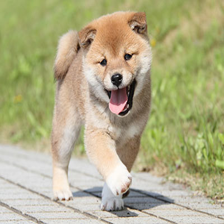

In [4]:
import numpy as np
import PIL.Image as Image

image_url = "https://dol.ismcdn.jp/mwimgs/7/1/670m/img_71c53c1d81500a1cf73a4f543e72413f27838.jpg" # 自分で指定

img = tf.keras.utils.get_file('inu.jpg', image_url)
img = Image.open(img).resize(IMAGE_SHAPE)
img


In [5]:
img = np.array(img) / 255.0
print(img.shape)

(224, 224, 3)


batch_sizeの分だけ次元を増やしてあげてから、predictしてみます。

In [6]:
img = np.expand_dims(img, 0)
result = classifier.predict(img)
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

2023-04-10 10:30:27.778344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


1/1 [==============================] - 3s 3s/step


274

予測結果が得られたので、このclass_idがなんに紐づいているのか定義から確認してみます。

In [7]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_name = imagenet_labels[predicted_class]
print("Predict result: {}".format(predicted_class_name))

10484/10484 [==============================] - 0s 0us/step
dingo


きちんと学習済みで推論できていることが確認できます。 
他にも何枚か試してみてください。

ロードしたモデルについても確認しておきます。

In [8]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


Trainable params: 0 からこのモデルが再トレーニングできないモデルなことがわかります。

## 最終層を再学習

学習済みモデルを利用することで、高精度な画像分類モデルを手軽に用意することが出来ました。    
しかしこのまま利用するには少し問題があります。再トレーニングができないので、このモデルで学習されていない画像に対しての分類ができないのです。

この問題を解決するために、Transfer Learning(転移学習)を行います。  
具体的には、最終層やいくつかの層をあえて取り外し、取り外した部分を再学習させるといったことを行います。  
これによって、学習済みモデルが持つ高精度な分類能力を維持しつつ、自分の問題設定に合わせた分類が可能となります。

では、実際に再学習させてみてTransfer Learningの効果を確認してみましょう。

## データセットの確認

まず、学習に使うデータセットを用意します。

https://www.tensorflow.org/datasets/catalog/overview  
上記のカタログの中から、  
https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet  
こちらのデータセットを今回は使います。

では、このデータセットをローカルに持ってきましょう。

In [21]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!tar -xf images.tar.gz

--2023-04-10 10:45:33--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-04-10 10:45:34--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-04-10 10:45:35--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-str

これから使うdataset apiに合わせるため、datasetフォルダの中にペットの種類毎のフォルダを作ってまとめておきます。

In [22]:
DATASET_DIR = "dataset"
for image in os.listdir("images"):
    pet_kind = '_'.join(image.split("_")[:-1])
    os.makedirs(os.path.join(DATASET_DIR, pet_kind), exist_ok=True)
    if image.split(".")[-1] == 'jpg':
        shutil.copy("images/{}".format(image), os.path.join(DATASET_DIR, pet_kind))

dataset apiの一つである[tf.keras.preprocessing.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory?hl=en)を使ってデータセットを読み込みましょう。

In [23]:
image_size = (224, 224)
batch_size = 16
DATASET_DIR = "dataset"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=1111,
    image_size=image_size,
    batch_size=batch_size,
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=1111,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7390 files belonging to 37 classes.
Using 5912 files for training.
Found 7390 files belonging to 37 classes.
Using 1478 files for validation.


読み込めたら、Fashion-MNISTと同じように画像データがどうなっているかを確認します。  
まず、データの形と、ラベルに何が存在するのかを確認してみましょう。

In [24]:
for images, labels in val_data.take(1):
    print("Image shape (batch, height, width, channel): " + str(images.shape))
    print("Label shape (batch, classes): " + str(labels.shape))
    print("Pet classes: \n" + str(val_data.class_names))

Image shape (batch, height, width, channel): (32, 224, 224, 3)
Label shape (batch, classes): (32, 37)
Pet classes: 
['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


バッチサイズや画像のサイズが指定した数になっていることが確認できると思います。  
また、Fashion-MNISTとは違い、今回のshapeには新たに画像のチャンネルが含まれています。  
ここから、データセットの画像がグレースケールではなく、RGBのカラー画像であることがわかります。

実際に画像を表示してみましょう。

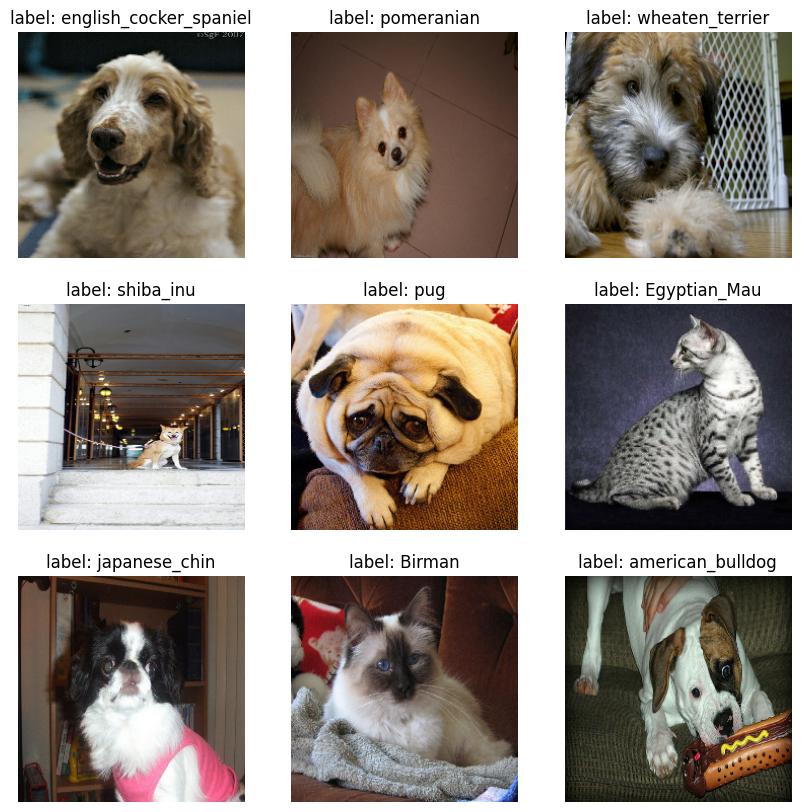

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
def view_dataset():
    for images, labels in val_data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("label: " + val_data.class_names[np.argmax(labels[i])])
            plt.axis("off")
            
view_dataset()

犬や猫の犬種/猫種のカラー画像が表示できたかと思います。

データセット全体の分布も見てみましょう。

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


<BarContainer object of 37 artists>

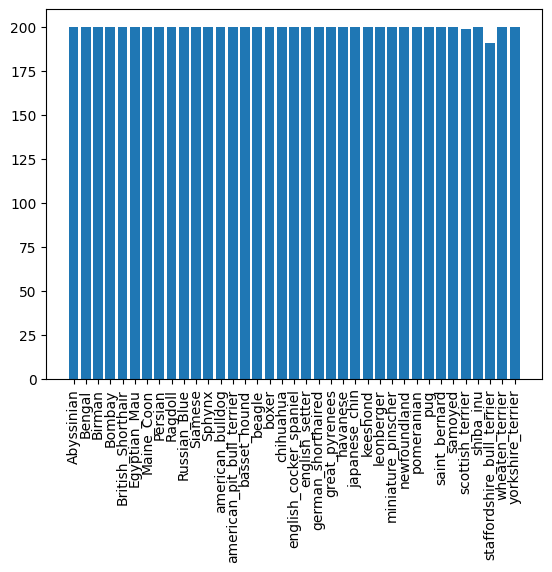

In [26]:
class_names = val_data.class_names
left = range(0, len(class_names))
height = np.zeros(len(class_names))
for data in [train_data, val_data]:
    for _, y in data:
        height += np.sum(y, axis=0)
plt.xticks(rotation=90)
plt.bar(left, height, tick_label=class_names, align="center")

ほとんどのデータが約200枚であることが確認できました。

では、試しにこのデータを先ほどの学習済みモデル、classifierで判別してみましょう。

1/1 [==============================] - 1s 561ms/step
(32, 1001)
1/1 [==============================] - 0s 38ms/step
(32, 1001)
1/1 [==============================] - 0s 46ms/step
(32, 1001)


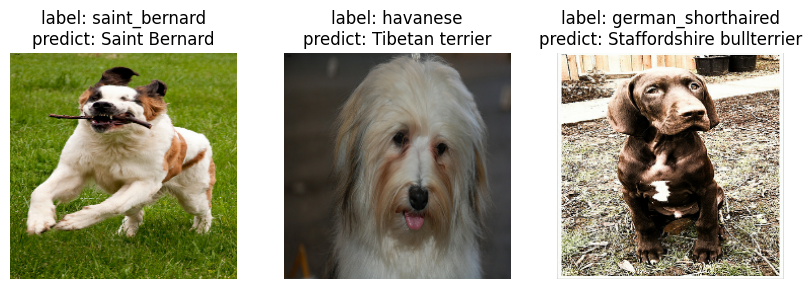

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in val_data.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        norm_images = images / 255
        result = classifier.predict(norm_images)
        print(result.shape)
        predicted_class = np.argmax(result[i], axis=-1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(
            "label: " + val_data.class_names[np.argmax(labels[i])] + 
            "\npredict: " + imagenet_labels[predicted_class]
        )
        plt.axis("off")

何回か繰り返して画像を確認してみてください。  
すると、犬種/猫種を判別できるものと全く判別できないものがあると思います。  
純粋な判別ミスもありますが、ここで理解してもらいたいことは、`classifier(mobilenet)が学習に使用しているImageNetデータセットのクラスに存在しないものは判別できない`ということです。

今回だと
- Havanese
- Wheaten_terrier
- American_Bulldog
- American_Pit_Bull_Terrier
- Bombay 
- Bengal
- Rusian_Blue
- Ragdoll
- British_Shorthair
- Ragdoll
- Abysinian
- Sphynx
- ...

あたりはImageNetに含まれていないので判別できません。    
ImageNetにどういったクラスのものが存在するか興味がある方は、https://starpentagon.net/analytics/ilsvrc2012_class_image/
でチェックしてみると良いです。(公式では現在検索できなくなっているようです。)

こういったものも含めて犬種/猫種を判別できるようにするというのが、Transfer Learningの主目的となります。

## Preprocessing
dataset apiを使ったおかげで、今回はデータのshapeを変える必要はなさそうです。

[tf.keras.layers.experimental.preprocessing.Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling)を用いて正規化だけ行っておきましょう。

In [28]:
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)
norm_train_dataset = train_data.map(lambda x, y: (norm_layer(x), y))
norm_val_dataset = val_data.map(lambda x, y: (norm_layer(x), y))

## モデルの構築
データを用意することができたので、学習に使用するモデルを構築します。

今回はTransfer Learningの有無による精度の差を確認したいので、  
Fashion-MNISTで使った通常のCNNモデルと、Transfer Learningするモデルの二つを構築していきます。

まず、CNNのモデルを定義しましょう。

In [45]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

NUM_CLASSES = len(class_names)

def cnn():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = "softmax"))
    return model

cnn_model = cnn()

次に、Transfer Learningのモデルを構築します。
特徴量ベクトルが取り出すことができる学習済みモデルを読み込みます。

https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4

ここからurlをコピーして使います。

In [46]:
feature_vector_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMAGE_SHAPE = (224, 224)

def mobilenet_v2():
    model = tf.keras.Sequential([
        hub.KerasLayer(feature_vector_url, input_shape=IMAGE_SHAPE+(3,)),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

transfer_learning_model = mobilenet_v2()
transfer_learning_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_5 (Dense)             (None, 37)                47397     
                                                                 
Total params: 2,305,381
Trainable params: 47,397
Non-trainable params: 2,257,984
_________________________________________________________________


最終層につけたDenseがTrainableで、特徴量ベクトルの層がUntrainableになっていることが確認できるかと思います。  
このTrainable部分を学習させることで、学習モデルにはない犬種/猫種も判別できるモデルにすることができます。

## Training

モデルの構築ができたので、訓練を開始します。

In [47]:
cnn_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'])

In [48]:
transfer_learning_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'])

tensorboardで結果が確認できるようにもしておきましょう。

In [ ]:
tensorboard_callback_cnn = tf.keras.callbacks.TensorBoard(log_dir="./logs/cnn_log")
tensorboard_callback_transfer = tf.keras.callbacks.TensorBoard(log_dir="./logs/transfer_log")

In [59]:
cnn_model.fit(x=norm_train_dataset, validation_data=norm_val_dataset, epochs=5, callbacks=[tensorboard_callback_cnn])

Epoch 1/5
  9/185 [>.............................] - ETA: 35s - loss: 0.5132 - categorical_accuracy: 0.8681

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 19/185 [==>...........................] - ETA: 32s - loss: 0.4678 - categorical_accuracy: 0.8816

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 39s 209ms/step - loss: 0.3718 - categorical_accuracy: 0.9093 - val_loss: 6.3605 - val_categorical_accuracy: 0.0792
Epoch 2/5
  9/185 [>.............................] - ETA: 35s - loss: 0.4101 - categorical_accuracy: 0.9028

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 19/185 [==>...........................] - ETA: 33s - loss: 0.4000 - categorical_accuracy: 0.8980

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 39s 209ms/step - loss: 0.3010 - categorical_accuracy: 0.9259 - val_loss: 7.7509 - val_categorical_accuracy: 0.0765
Epoch 3/5
  9/185 [>.............................] - ETA: 34s - loss: 0.5647 - categorical_accuracy: 0.8785

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 19/185 [==>...........................] - ETA: 32s - loss: 0.4582 - categorical_accuracy: 0.8964

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 39s 209ms/step - loss: 0.3126 - categorical_accuracy: 0.9300 - val_loss: 6.8903 - val_categorical_accuracy: 0.0805
Epoch 4/5
  9/185 [>.............................] - ETA: 35s - loss: 0.3552 - categorical_accuracy: 0.9062

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 19/185 [==>...........................] - ETA: 33s - loss: 0.3573 - categorical_accuracy: 0.9095

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 39s 210ms/step - loss: 0.2771 - categorical_accuracy: 0.9322 - val_loss: 7.3865 - val_categorical_accuracy: 0.0825
Epoch 5/5
  9/185 [>.............................] - ETA: 34s - loss: 0.2337 - categorical_accuracy: 0.9340

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 19/185 [==>...........................] - ETA: 33s - loss: 0.2807 - categorical_accuracy: 0.9260

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 39s 209ms/step - loss: 0.2349 - categorical_accuracy: 0.9427 - val_loss: 7.9142 - val_categorical_accuracy: 0.0819


In [62]:
transfer_learning_model.fit(x=norm_train_dataset, validation_data=norm_val_dataset, epochs=5, callbacks=[tensorboard_callback_transfer])

Epoch 1/5
 13/185 [=>............................] - ETA: 7s - loss: 0.0656 - categorical_accuracy: 0.9904

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 23/185 [==>...........................] - ETA: 6s - loss: 0.0753 - categorical_accuracy: 0.9851

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 10s 51ms/step - loss: 0.0718 - categorical_accuracy: 0.9890 - val_loss: 0.2327 - val_categorical_accuracy: 0.9215
Epoch 2/5
 17/185 [=>............................] - ETA: 7s - loss: 0.0616 - categorical_accuracy: 0.9890

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 27/185 [===>..........................] - ETA: 6s - loss: 0.0576 - categorical_accuracy: 0.9907

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 10s 52ms/step - loss: 0.0562 - categorical_accuracy: 0.9942 - val_loss: 0.2282 - val_categorical_accuracy: 0.9276
Epoch 3/5
 17/185 [=>............................] - ETA: 6s - loss: 0.0482 - categorical_accuracy: 0.9945

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 26/185 [===>..........................] - ETA: 6s - loss: 0.0498 - categorical_accuracy: 0.9928

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 10s 52ms/step - loss: 0.0460 - categorical_accuracy: 0.9956 - val_loss: 0.2329 - val_categorical_accuracy: 0.9242
Epoch 4/5
 17/185 [=>............................] - ETA: 6s - loss: 0.0422 - categorical_accuracy: 0.9963

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 26/185 [===>..........................] - ETA: 6s - loss: 0.0426 - categorical_accuracy: 0.9964

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 10s 51ms/step - loss: 0.0383 - categorical_accuracy: 0.9978 - val_loss: 0.2257 - val_categorical_accuracy: 0.9310
Epoch 5/5
 16/185 [=>............................] - ETA: 6s - loss: 0.0360 - categorical_accuracy: 1.0000

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 26/185 [===>..........................] - ETA: 7s - loss: 0.0343 - categorical_accuracy: 1.0000

Corrupt JPEG data: premature end of data segment


185/185 [==============================] - 10s 53ms/step - loss: 0.0314 - categorical_accuracy: 0.9990 - val_loss: 0.2217 - val_categorical_accuracy: 0.9269


## 可視化
訓練が終わったら、各モデルのlossとaccuracyの推移を確認してみます。

In [65]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [66]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 17527), started 1:46:13 ago. (Use '!kill 17527' to kill it.)

両モデルの違いを確認できたでしょうか。

各モデルの個別の予測結果も確認しましょう。  
先程作ったview_datasetメソッドを改良して、ラベルの他にpredictも出力できるようにしましょう。

In [3]:
def predict_dataset(model=None):
    for images, labels in val_data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            image = images[i].numpy()
            plt.imshow(images[i].numpy().astype("uint8"))
            if not model:
                plt.title("label: " + val_data.class_names[np.argmax(labels[i])])
            else:
                norm_img = image / 255
                result = model.predict([norm_img])
                plt.title(
                    "label:" + val_data.class_names[np.argmax(labels[i])] +
                    "\npredict:" + val_data.class_names[np.argmax(result[0])]
                )
            plt.axis("off")

1/1 [==============================] - 0s 34ms/step


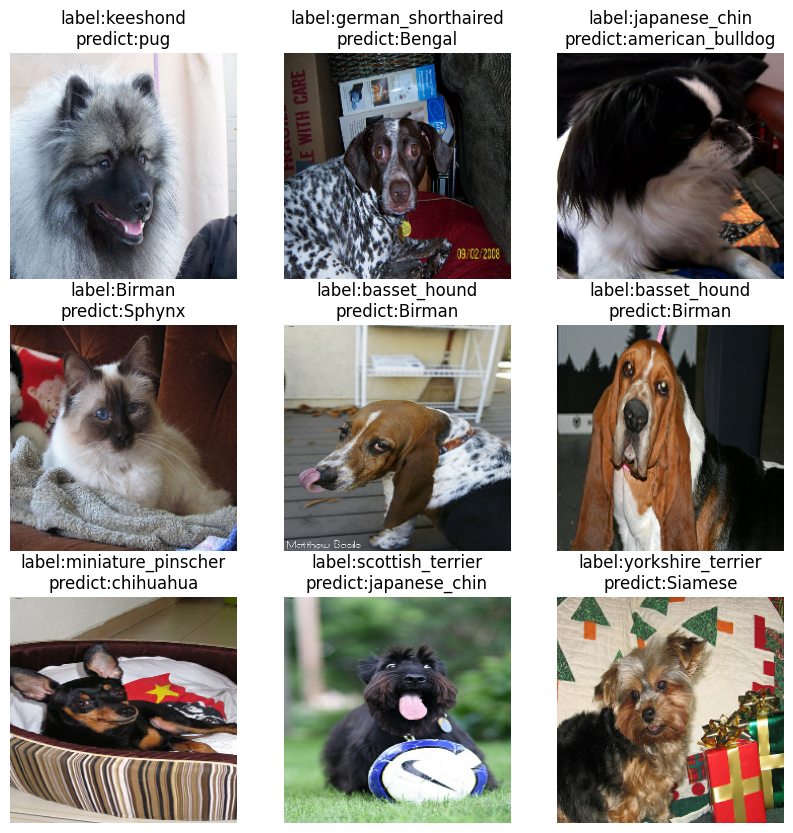

In [39]:
plt.figure(figsize=(10, 10))
predict_dataset(cnn_model)

1/1 [==============================] - 0s 39ms/step


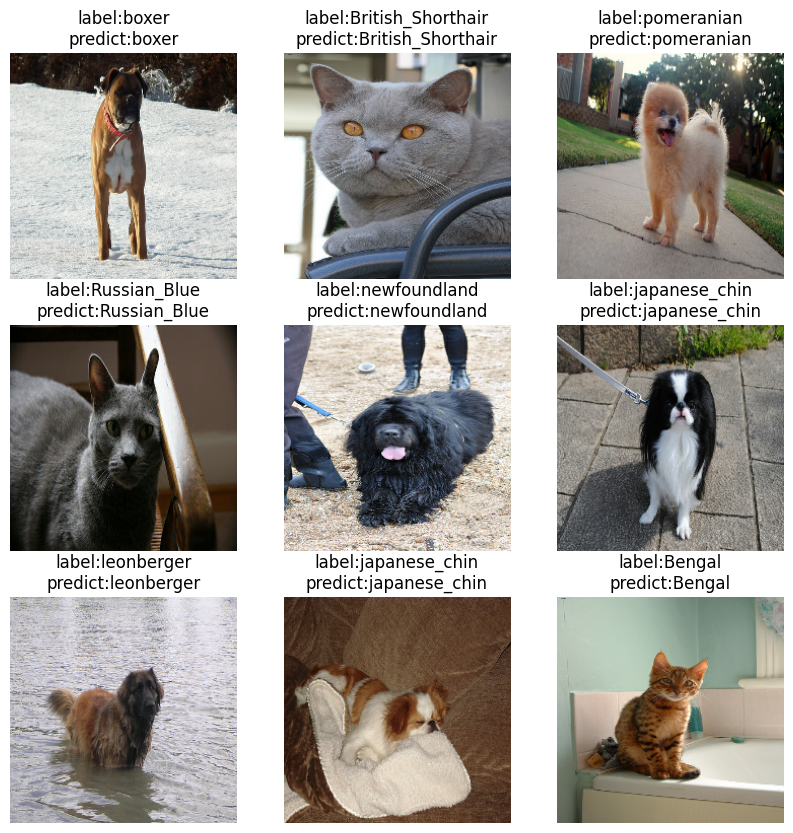

In [40]:
plt.figure(figsize=(10, 10))
predict_dataset(transfer_learning_model)

ImageNetデータセットにない犬種/猫種も予測できたでしょうか。

## 保存
出来上がったモデルは現時点では、notebookのメモリ上にしかありません。これを保存します。  
ここでは、より精度の良いTranfer modelを保存しておきましょう。
save_formatはtensorflow2.0以降のデフォルトの保存形式になっているsaved_model形式で保存を行うための指定です。

In [68]:
USER    = "username" # 自分の名前
BUCKET  = "mixi-ml-handson-2023"
VERSION = "001"

transfer_learning_model.save("gs://{}/{}/{}".format(BUCKET, USER, VERSION), save_format="tf")

INFO:tensorflow:Assets written to: gs://2022-machine-learning-test/rio/transfer_model/assets


INFO:tensorflow:Assets written to: gs://2022-machine-learning-test/rio/transfer_model/assets
